In [1]:
using PyPlot
using LinearAlgebra
using Statistics
include("boundary_conditions.jl");

In [2]:
include("gradient.jl")

function (∇::GradientOperator)(u; result=nothing, reverse=false)
    dudx = isnothing(result) ? zeros(∇.nx + 1) : result
    
    calculate_gradient!(dudx, u, ∇.δx, ∇.nx)
    for (bnd, bc) in zip(∇.bnds, ∇.bcs)
        calculate_gradient!(dudx, u, ∇.δx, ∇.nx, bnd, bc)
    end
    
    if reverse dudx .*= -1.0 end
    return dudx
end

In [3]:
include("inplace_periodic_solver.jl")

apply!(::InPlacePeriodicSolver, ::PeriodicBC) = nothing
solution(ps::InPlacePeriodicSolver) = ps.u
gradient(ps::InPlacePeriodicSolver) = let periodic = PeriodicBC()
    GradientOperator(ps.nx, ps.δx, (periodic, periodic), (:left, :right))
end

gradient (generic function with 1 method)

In [4]:
include("iterative_methods.jl")

function solve!(ps::InPlacePeriodicSolver, rhs)
    b = rhs .* ps.Δx .^ 2 # assembled rhs
    ps.u .= randn(ps.nx)
    jacobi(ps.u, b; K=ps.maxiter, ϵ=ps.tol)
end

solve! (generic function with 1 method)

In [20]:
using SparseArrays
include("linear_solver.jl")

solution(ps::LinearSolver) = ps.u
gradient(ps::LinearSolver) = GradientOperator(ps.nx, ps.δx, ps.bcs, ps.bnds)

gradient (generic function with 2 methods)

In [6]:
import IterativeSolvers: cg!

function solve!(ps::LinearSolver, rhs)
    b = ps.b .+ rhs .* ps.Δx .^ 2 # assembled rhs
    ps.u  .= rand(ps.nx)
    cg!(ps.u, ps.A, b)
    return NaN
end

solve! (generic function with 2 methods)

In [7]:
struct MutligridSolver end
struct FastFourierTransformSolver end

In [22]:
xf = 0.0:0.01:1.0
dbc = DirichletBC(π)
bc = PeriodicBC()
ps = LinearSolver(xf, left=bc, right=bc)
xc = 0.5 .* xf[1:end-1] .+
     0.5 .* xf[2:end]
φref = -sin.(2π * 2xc)

f(x) = (2π * 2)^2 * sin(2π * 2x)
ρ = f.(xc)
nothing

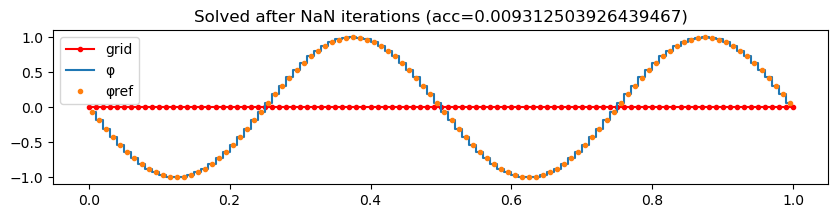

In [25]:
apply!(ps, bc,  :left)
apply!(ps, bc, :right)

it = solve!(ps, -ρ)
φ  = solution(ps)
φ.-= mean(φ) # substract mean value when both boundary conditions are periodic
figure(figsize=(10, 2))
title("Solved after $it iterations (acc=$(norm(φ - φref)))")
plot(xf, zero(xf), "r.-")
step(xc, φ, where="mid")
plot(xc, φref, ".")
legend(["grid", "φ", "φref"]);

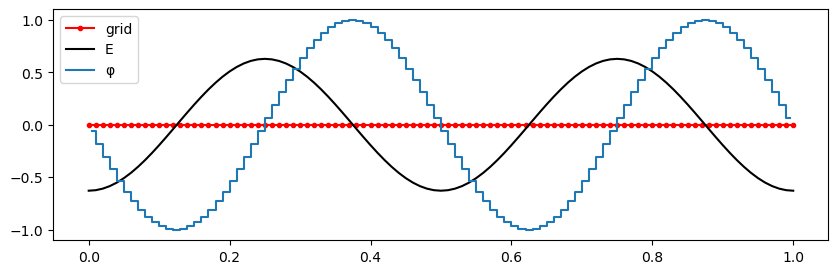

In [26]:
∇ = gradient(ps)
E = ∇(φ)
figure(figsize=(10, 3))
plot(xf, zero(xf), "r.-")
plot(xf, 0.05E, "k-")
step(xc, φ, where="mid")
legend(["grid", "E", "φ"]);